In [152]:
import time
import bisect 
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Module.count import *
from Module.allo_chain import *
from Module.Curve_Fitting_MLE import *
from Module.network import *
from scipy.optimize import curve_fit
from matplotlib import rcParams

#https://matplotlib.org/3.1.1/tutorials/text/mathtext.html
plt.style.use('classic')
%matplotlib inline


In [153]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)
##if anything gets into trouble, use (1) instead of (2), and vise versa.
name = 'Moby-Dick'
filename = name + '.txt' #change filename if you want to get statictical information of another txt file

In [154]:
##text file.
big, syl, word, longest = info(filename, encode)
#count_allo(word, syl)

read file successfully!
Successfully count word freqency!(Moby-Dick.txt)
Successfully count syl freqency!
Successfully build data frames!


In [155]:
V, H = geometric_sequence(word, syl)

In [159]:
def chose_point(m, n, V, H, big, longest):
    '''chose the points in (m, n), (m+1, n+1), ... rectangles, where m >= n.
    
    parameters:
    1. m, n: int
       m, n >= 1
    2. V, H: list or np.array
       V and H are the coordinates of the sequence {V} and {H}.
       You should get these two from 
             V, H = geometric_sequence(word, syl)
       where geometric_sequence(word, syl) is the function of count.py

    3. big, longest: pandas.DataFrame, int
        the output of the function info()    
    
    return: 
    points = [[(x_m,y_n),...], [(x_(m+1), y_(n+1)),...], ...]
    
    (m, n) rectangle denotes those points whose x in (V_m+1, V_m] while y in (H_n+1, H_n]
    '''
    points = [[] for j in range(min(len(V) - m, len(H) - n))]
    for j in range(min(len(V) - m, len(H) - n)):
        #https://thispointer.com/python-pandas-select-rows-in-dataframe-by-conditions-on-multiple-columns/
        V_word = big.loc[(big['wordRank'] < V[j+m-1]) & (big['wordRank'] > V[j+m])]
        for i in range(longest): #0th_syl ~ (longest-1)_th_syl
            H_syl = V_word[(V_word[str(i) + "th_syl_rank"] < H[j+n-1]) & (V_word[str(i) + "th_syl_rank"] > H[j+n])]
            ind = H_syl.index #if I don't use index here, the content of points will be series not value
            for k in ind:
                points[j].append((H_syl.loc[k, 'wordRank'], H_syl.loc[k, str(i) + "th_syl_rank"]))
    return points

def left_upper(m, n, points):
    '''select points located in left upper of each rectangles
    
    paras:
    1. m, n: int
        the same as m, n in chose_point()
    2. points: array
        output of chose_point(), namely [[(x_1,y_2),...]_(m,n), [(x_1,y_2),...]_(m+1,n+1), ...]
        
    return:
    lup = [[(lux_m,luy_n),...], [(lux_(m+1), luy_(n+1)),...], ...] after left upper selection
    
    lup denotes "left upper point"
    '''
    
    lup = [[] for i in range(len(points))]
    for i in range(len(points)):
        for p in points[i]:
            if p[1] - H[i+n] > (p[0] - V[i+m])*(H[i+n-1] - H[i+n])/(V[i+m-1] - V[i+m]):
                lup[i].append(p)
            #Sometimes the left upper points in retangle are not follow a concave curve, so that lup[i]=[].
            #Then 
            if lup[i] == []:
                
    return lup

def sort_point(m, n, points):
    '''
    sort points in each rectangle to make analysis easier
    
    paras:
    1. m, n: int
        the same as m, n in chose_point()
    2. points: array
        output of chose_point(), namely [[(x_1,y_2),...]_(m,n), [(x_1,y_2),...]_(m+1,n+1), ...]

    
    return:
    1. px: 
        [x_m, ..., x_(m+1), ...]
    2. py: 
        [y_n, ..., y_(n+1), ...]    
    '''
    for i in points:
        #sort list with key
        i.sort(key = lambda x: x[1], reverse = True)
    px = []
    py = []
    for i in range(5):
        if points[i] == []:
            print ('the (%d, %d) block have no points.' % (i+m, i+n))
        for j in points[i]:
            px.append(j[0])
            py.append(j[1])
    return px, py

def Tv(r, p):
    '''
    input:
    r: ndarray
    data points after denosing, where r = [rx1, rx2, ..., rxn, ry1, ry2, ..., ryn]
    p: ndarray
    data with noise, where p = [x1, x2, ..., xn, y1, y2, ..., yn]
    
    output:
    a function used to denoise
    '''
    def penalty(u, M):
        #This penalty function is used to lower the influence of outliers
        if abs(u) <= M:
            return u ** 2
        elif abs(u) > M:
            return M * (2 * abs(u) - M)
    t = 0
    for i in range(len(p)):
        t = t + penalty(r[i] - p[i], 50)
    
    #see taxicab distance
    Lambda = 1 #regularziation parameters
    rl = int(len(r)/2)
    return sum(np.square(r[1:rl]-r[:rl - 1])) + sum(np.square(r[rl + 1:]-r[rl:-1])) + Lambda*t

def DENOISE(m, n, points, toler = 50):
    '''chose left_upper part in each rectangle and denoise them via Tv.
    
    paras:
    1. m, n: int
        the same as m, n in chose_point()
    2. points: array
        output of chose_point(), namely [[(x_1,y_2),...]_(m,n), [(x_1,y_2),...]_(m+1,n+1), ...]
    3. toler: number, default = 50
        control the tolerance of minimize
    
    output:
    1. luptx: 1D array
        array of x coordinate for (m,n)~(m+5,n+5) after denoising 
    2. lupty: !D array
        array of y coordinate for (m,n)~(m+5,n+5) after denoising
    '''
    
    lup = left_upper(m, n, points)
    lupx, lupy = sort_point(m, n, lup)
    lupxy = np.array(lupx + lupy)  #lupxy = [x1, x2, ..., xn, y1, y2, ..., yn]
    RR = minimize(Tv, lupxy, args = lupxy, method='CG', tol = toler)
    luptx = RR.x[:int(len(RR.x)/2)]
    lupty = RR.x[int(len(RR.x)/2):]
    return luptx, lupty

def moving_avg(px, py, Range, num_part = 50):
    '''use moving average on (px,py), ruturn p_avg
    ---input:
    px, py: 1-D list
    Range: the x-range of data points
    num_part: number of segmentation, i.e. segment pi into num_part parts. 
              the moving period = (max(Range)-min(Range))/num_part
    
    ---return:
    p_avg: (px,py) after moving average
    '''
    period = (max(Range) - min(Range))/num_part
    px_avg = [[] for i in range(num_part)]
    py_avg = [[] for i in range(num_part)]
    p = [(px[i], py[i]) for i in range(len(px))]
    
    for j in p:
        #check every points
        for i in range(num_part):
            if (j[0] >= min(Range) + i*period) & (j[0] <= min(Range) + (i+1)*period):
                px_avg[i].append(j[0])
                py_avg[i].append(j[1])
                break    
    x_avg, y_avg = [], []
    for i in range(num_part):
        if (px_avg[i] == []) or (py_avg[i] == []):
            x_avg.append(float('nan'))
            y_avg.append(float('nan'))
        else:
            x_avg.append(np.mean(px_avg[i]))
            y_avg.append(np.mean(py_avg[i]))        
    return x_avg, y_avg

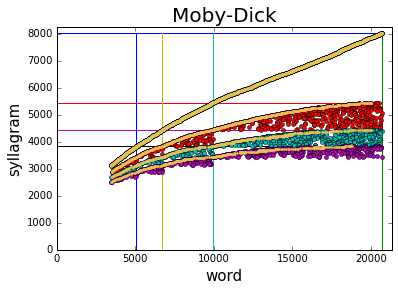

In [162]:
N = 4
num_part = 50
#-----------------------------plot horizontal and vertical lines
Slice_number = 50 #this value decide the number of points on horizontal and vertical lines
number_of_lines = 4
x_range = np.linspace(0, max(V), Slice_number)
y_range = np.linspace(0, max(H), Slice_number)

for i in range(number_of_lines):
    x_const = [V[i] for j in range(Slice_number)]#x_const =[V[i], V[i], ..., V[i]], Slice_number elements
    y_const = [H[i] for j in range(Slice_number)] #y_const =[H[i], H[i], ..., H[i]], Slice_number elements
    plt.plot(x_range, y_const) #plot y=H[i]
    plt.plot(x_const, y_range) #plot x=V[i]   
#-----------------------------   
g = {}
glu = {}
#plt.locator_params(axis='y', nbins=5)
#pick up points on scaling line
for n in range(1, N+1):
    (m, n) = (1, n)
    points = chose_point(m, n, V, H, big, longest)
    px, py = sort_point(m, n, points)
    plt.plot(px, py,'o', markersize = '4')
    if n == 1:
        luptx, lupty = px, py
    else:
        luptx, lupty = DENOISE(m, n, points)
    glu['g' + str(n)] = (luptx, lupty)
    plt.plot(luptx, lupty,'.' ,markersize = '4', color = '#e9bf53')
    #moving average
    Range = [0.25*V[0], V[0]]
    x_avg, y_avg = moving_avg(luptx, lupty, Range, num_part)
    g['g' + str(n)] = (x_avg, y_avg)
plt.xlim([0, V[0]*1.03])
plt.ylim([0, H[0]*1.03])
plt.xlabel('word', size = 15)
plt.ylabel('syllagram', size = 15)  
plt.title(name, size = 20)
plt.show()

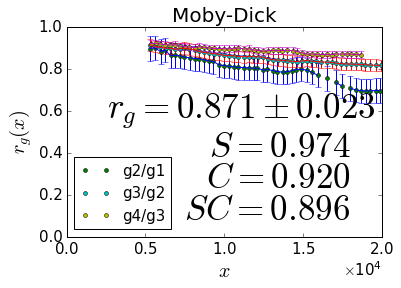

In [161]:
Path = ''

num_part = max([len(g[i][0]) for i in g])
len_g = len(g)
y = {}
x = {}
STD = {} #STD of g_n/g_(n+1)
weight = {} #number of data of g_n/g_(n+1)
r = {} #average ratio of g_n/g_(n+1)
for k in range(1, len_g):
    gk1 = 'g' + str(k+1)
    gk = 'g' + str(k)
    y[gk1 + '/' + gk] = [g[gk1][1][j]/g[gk][1][j] for j in range(num_part)]
    x[gk1 + '/' + gk] = [0.5*g[gk1][0][j] + 0.5*g[gk][0][j] for j in range(num_part)]

    y_k = [i for i in y[gk1 + '/' + gk] if i==i] # this is y without NAN
    STD[gk1 + '/' + gk] = round(np.std(y_k), 3)
    weight[gk1 + '/' + gk] = len(y_k)
    r[gk1 + '/' + gk] = round(np.mean(y_k), 3)

fig, ax = plt.subplots()
#calculate SC value excluding g2/g1
error = {}
for i in STD:
    if i != 'g2/g1':
        error[i] = STD[i]
del weight['g2/g1'], r['g2/g1']
tot = sum([weight[w] for w in weight])
R = sum([weight[i]*r[i]/tot for i in weight])
ERROR = (sum([weight[i]*error[i]**2/tot for i in weight]))**0.5
EE = (sum([weight[i]*error[i]/tot for i in weight]))


C = {}
for i in x:
    px = x[i]
    py = y[i]
    std = STD[i]
    if i != 'g2/g1':
        C[i] = weight[i]/len(py)
        if C[i] < 0.8:
            print('C < 0.8: %s, %f' % (i, C[i]))
    ax.errorbar(px, py, yerr = std) #plot errorbar
    plt.plot(px, py,'o', markersize = '4', label = i)
    plt.legend(loc = 'best', prop = {'size': 15})

C_value = np.mean([C[i] for i in C])
S_value = 1 - ERROR/R

xmin, xmax = plt.xlim([0,None])
ymin, ymax = plt.ylim([0,None])
plt.text(xmax*0.98, ymax*0.5, '$r_g=%.3f\pm %.3f$' % (R,ERROR), fontsize=35, verticalalignment='bottom', horizontalalignment='right')
plt.text(xmax*0.9, ymax*0.35, '$S=%.3f$' % (S_value), fontsize=35, verticalalignment='bottom', horizontalalignment='right')
plt.text(xmax*0.9, ymax*0.2, '$C=%.3f$' % (C_value), fontsize=35, verticalalignment='bottom', horizontalalignment='right')
plt.text(xmax*0.9, ymax*0.05, '$SC=%.3f$' % (S_value*C_value), fontsize=35, verticalalignment='bottom', horizontalalignment='right')
plt.xlabel('$x$', size = 20)
plt.ylabel('$r_g(x)$', size = 20)
ax.tick_params(axis='x', labelsize=15) 
ax.tick_params(axis='y', labelsize=15)
#https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.ticklabel_format.html
#https://atmamani.github.io/cheatsheets/matplotlib/matplotlib_2/
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter) 
#https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib
ax.yaxis.offsetText.set_fontsize(15)
ax.xaxis.offsetText.set_fontsize(15)

#https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
plt.gcf().subplots_adjust(left = 0.17, bottom = 0.17)
plt.title(name, size = 20)
try:
    if Path == '':
        #fig.savefig('rg of ' + name + '.' + FORMAT, dpi = 400, format = FORMAT)
        plt.show()
    else:
        fig.savefig(Path + 'rg of ' + name + '.' + FORMAT, dpi = 400, format = FORMAT)
        plt.close()
except:
    plt.show()